In [1]:
import sys
sys.path.append('../')

import jax
# set jax precision 64 bit
jax.config.update("jax_enable_x64", True)

from jax import vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
from src.training import train_model
from flax import linen as nn

In [ ]:
data_dir = "/home/emastr/moment-constrained-cryo-em/project_2/data/"
data = jnp.load(f"{data_dir}/train_data.npy", allow_pickle=True).item()

x_train_pad = data["x"]#[:,:,:-2]
y_train_pad = data["y"]
mask_train_pad = data["mask"]


class Model(nn.Module):
    
    def setup(self):
        self.lin = nn.Dense(1)
        
    def __call__(self, x, mask=None):
        x = x.flatten()
        x = self.lin(x) #return self.lin(x)# + jnp.sum(x)
        return x

key = jax.random.PRNGKey(0)

# MODEL
num_epochs= 2000
num_heads = 1
ff_hidden_dim = 128
num_layers = 6
batch_size = 8

key = jax.random.PRNGKey(0)
mnum_data, seq_len, embed_dim = x_train_pad.shape
model = Model()
params = model.init(key, x_train_pad[0])

loss_pointwise = lambda param, x, y: (model.apply(param, x) - y)**2
loss_fcn = lambda param: jnp.mean(vmap(loss_pointwise, (None, 0, 0))(param, x_train_pad, y_train_pad))

print(f"loss:{loss_fcn(params)}")
for i in range(10000):
    loss, grads = jax.value_and_grad(loss_fcn)(params)
    params = jax.tree.map(lambda p, g: p - 0.1*g, params, grads)
    print(loss, end='\r')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


loss:53.53648021259098


[0.01697764]
[-0.00674868]
[-0.01282304]
[-0.04982848]
[-0.06620834]
[0.04669315]
[-0.0796339]
[0.08150409]
[0.03563858]
[0.11095403]


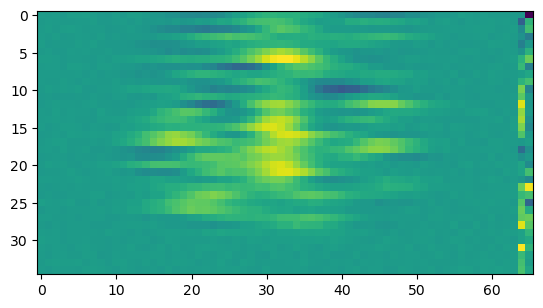

In [3]:
kern = params['params']['lin']['kernel'].reshape(x_train_pad[0].shape)
bias = params['params']['lin']['bias']
plt.imshow(kern)

for idx in range(10):
    print(jnp.sum(kern * x_train_pad[idx]) + bias- y_train_pad[idx])


In [4]:
# Training observations:
# - Loss is choppy (shoots back up and then down)
# - Stays at 0.1
# - Model should be able to fit the data

# Next steps:
# - Try to overfit a simple function (1. everywhere worked)
# - Try to overfit on a small data set ()
# - 